In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

import sys
sys.path.append('../src')
from models import ModelConstructor
from utils import normalize, calc_rf_indices, calc_fft_index

# figure settings
DPI=600
plt.rcParams.update({'font.family': 'Arial'})
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'axes.labelsize': 24})
plt.rcParams.update({'xtick.labelsize': 20})
plt.rcParams.update({'ytick.labelsize': 20})
plt.rcParams.update({'axes.titlesize': 24})
plt.rcParams.update({'axes.titleweight': 'bold'})

# standard (red) and biomimetic (blue) color
colors = np.array([[168, 14, 53], [0, 82, 137]])
colors = colors/255

# constants
IMG_SIZE = (256, 256, 3)
NUM_CLASSES = 1000

#Path Settings
PROJECT_PATH = ".."
MODEL_PATH = os.path.join(PROJECT_PATH, "trained_models", "v1")
RESULT_PATH = os.path.join(PROJECT_PATH, "result", "v1")
FIGURE_PATH = os.path.join(PROJECT_PATH, "figures")
if not os.path.exists(FIGURE_PATH):
    os.mkdir(FIGURE_PATH)

/opt/anaconda3/envs/tf241/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
def get_path(start_path, model_name, train_version, repeat, create=False):
    path = os.path.join(start_path, model_name, str(train_version), str(repeat))
    if create and (not os.path.exists(path)):
        os.makedirs(path)    
    return path

In [3]:
def calc_HSV_color_index(img, n=0):
    '''
    Calculate the HSVcolor index of an image.

    args:
    img(np.array): the image to calculate the color index
    n(int): the number of top color pixels to consider. 
           If n=0, the mean of all pixels is returned.
    '''
    # Arg check
    assert isinstance(img, np.ndarray), "Image must be a numpy array"
    assert isinstance(n, int), "n must be an integer"
    assert n >= 0, "n must be greater than or equal to 0"

    # Calculate saturation
    r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    maxc = np.maximum(np.maximum(r, g), b)
    minc = np.minimum(np.minimum(r, g), b)
    
    s = np.zeros_like(maxc)
    nonzero = maxc != 0
    s[nonzero] = (maxc[nonzero] - minc[nonzero]) / maxc[nonzero]

    if n == 0:
        return np.mean(s, axis=None)
    else:
        return np.mean(np.flip(np.sort(s, axis=None))[0:n])

In [4]:
def calc_CIELAB_color_index(img, n=0):
    '''
    Calculate the CIELAB color index of an image.

    args:
    img(np.array): the image to calculate the color index
    n(int): the number of top color pixels to consider. 
           If n=0, the mean of all pixels is returned.
    '''
    # Arg check
    assert isinstance(img, np.ndarray), "Image must be a numpy array"
    assert isinstance(n, int), "n must be an integer"
    assert n >= 0, "n must be greater than or equal to 0"

    # Convert RGB to XYZ
    r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    x = 0.4124564 * r + 0.3575761 * g + 0.1804375 * b
    y = 0.2126729 * r + 0.7151522 * g + 0.0721750 * b
    z = 0.0193339 * r + 0.1191920 * g + 0.9503041 * b

    # Convert XYZ to Lab
    xn, yn, zn = 0.95047, 1.0, 1.08883  # D65 illuminant
    
    def f(t):
        delta = 6/29
        return np.where(t > delta**3, t**(1/3), t/(3*delta**2) + 4/29)
    
    fx = f(x/xn)
    fy = f(y/yn)
    fz = f(z/zn)
    
    L = 116 * fy - 16
    a = 500 * (fx - fy)
    b = 200 * (fy - fz)
    
    # Calculate chroma (C*)
    chroma = np.sqrt(a**2 + b**2)

    if n == 0:
        return np.mean(chroma, axis=None)
    else:
        return np.mean(np.flip(np.sort(chroma, axis=None))[0:n])

In [5]:
def get_rf_indices(model_name, train_version, repeat, regimen_list, n_top_col_pixel=48):
    # get path
    model_path = get_path(MODEL_PATH, model_name, train_version, repeat)

    # construct model
    model = ModelConstructor(model_name=model_name, 
                             input_shape=IMG_SIZE, 
                             num_classes=NUM_CLASSES).getModel()
    # get rf indices
    color_ind_all = []
    fftfreq_ind_all = []
    fftaz_ind_all = []
    norm_weights = []
    alt_fftfreq_ind_all = []
    color_ind_12_all = []
    color_ind_1_all = []
    color_ind_HSV_all = []
    color_ind_CIELAB_all = []
    for regimen in regimen_list:
        # get weights
        m = os.path.join(model_path, regimen)
        model.load_weights(m).expect_partial()
        w0 = model.layers[4].get_weights()[0]

        # normalize weights
        w0_norm = np.zeros(w0.shape)
        num_rf = w0.shape[3]
        for i in range(num_rf):
            w0_norm[:,:,:,i] = normalize(w0[:,:,:,i])   
        norm_weights.append(w0_norm)

        # get rf indices
        [color_index, fft_freq_index, fft_az_index] = calc_rf_indices(w0, n_top_col_pixel=n_top_col_pixel)
        color_ind_all.append(color_index)
        fftfreq_ind_all.append(fft_freq_index)
        fftaz_ind_all.append(fft_az_index)

        # get alternative fft index
        alt_fftfreq_ind = np.zeros(w0.shape[3])
        for i in range(w0.shape[3]):
            n_times = 100
            angle_interval = 1
            peak_freq, mrl, r_index, r_means, a_index, a_means = calc_fft_index(w0_norm[:,:,:,i], n_times=n_times, angle_interval=angle_interval, return_raw=True)
            alt_fftfreq_ind[i] = r_index[np.argmax(r_means)]/n_times
        alt_fftfreq_ind_all.append(alt_fftfreq_ind)

        # get top 12 color index
        color_ind_12 = calc_rf_indices(w0, n_top_col_pixel=12, color_only=True)
        color_ind_12_all.append(color_ind_12)

        # get top 1color index
        color_ind_1 = calc_rf_indices(w0, n_top_col_pixel=1, color_only=True)
        color_ind_1_all.append(color_ind_1)

        # get HSV color index
        color_ind_HSV = np.array([calc_HSV_color_index(w0_norm[:,:,:,i], n_top_col_pixel) for i in range(num_rf)])
        color_ind_HSV_all.append(color_ind_HSV)

        # get CIELAB color index
        color_ind_CIELAB = np.array([calc_CIELAB_color_index(w0_norm[:,:,:,i], n_top_col_pixel) for i in range(num_rf)])
        color_ind_CIELAB_all.append(color_ind_CIELAB)
        
    
    return color_ind_all, fftfreq_ind_all, fftaz_ind_all, norm_weights, alt_fftfreq_ind_all, color_ind_12_all, color_ind_1_all, color_ind_HSV_all, color_ind_CIELAB_all

In [6]:
def create_rf_scatterplot(regimen_list, regimen_names, color_ind_all, fftfreq_ind_all, fftaz_ind_all, 
                          figure_path, freq_range=(2, 7.6), col_max=0.82, col_min=0, col_step=0.1):
    fig, ax = plt.subplots(1, len(regimen_list), figsize=(9*len(regimen_list), 6))
    for j, regimen in enumerate(regimen_list):
        s = ax[j].scatter(color_ind_all[j], fftfreq_ind_all[j], c=fftaz_ind_all[j], 
                        vmin=0, vmax=0.9, s=100, edgecolors='black', linewidth=0.3)
        plt.colorbar(s, ax=ax[j], ticks=np.arange(0, 1.0, 0.1), 
                    label='Orientation selectivity', pad=0.02)
        ax[j].set_xticks(np.arange(col_min, col_max, col_step))
        ax[j].set_xlim([col_min, col_max])
        ax[j].set_ylim(freq_range)
        ax[j].set_xlabel("Color metric")
        ax[j].set_ylabel("Frequency metric")
        ax[j].set_title(regimen_names[j], fontsize=24, fontweight="bold")

    plt.tight_layout()
    fig.savefig(figure_path, dpi=DPI)

In [7]:
model_name = "alexnet22_48"
train_version = 0
figure_path = os.path.join(FIGURE_PATH, model_name, str(train_version), "AdditionalFigures")
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

regimen_list = ["c0-100_c0-100", "g4-100_c0-100"]
regimen_names = ["Standard", "Biomimetic"]

In [8]:
color_ind_all = []
fftfreq_ind_all = []
fftaz_ind_all = []
alt_fftfreq_ind_all = []
color_ind_12_all = []
color_ind_1_all = []
color_ind_HSV_all = []
color_ind_CIELAB_all = []
weights_all = []
for repeat in range(5):
    color_ind, fftfreq_ind, fftaz_ind, weights, alt_fftfreq_ind, color_ind_12, color_ind_1, color_ind_HSV, color_ind_CIELAB = get_rf_indices(model_name, train_version, repeat, regimen_list)
    color_ind_all.append(color_ind)
    fftfreq_ind_all.append(fftfreq_ind)
    fftaz_ind_all.append(fftaz_ind)
    alt_fftfreq_ind_all.append(alt_fftfreq_ind)
    color_ind_12_all.append(color_ind_12)
    color_ind_1_all.append(color_ind_1)
    weights_all.append(weights)
    color_ind_HSV_all.append(color_ind_HSV)
    color_ind_CIELAB_all.append(color_ind_CIELAB)

## Alternative fft index

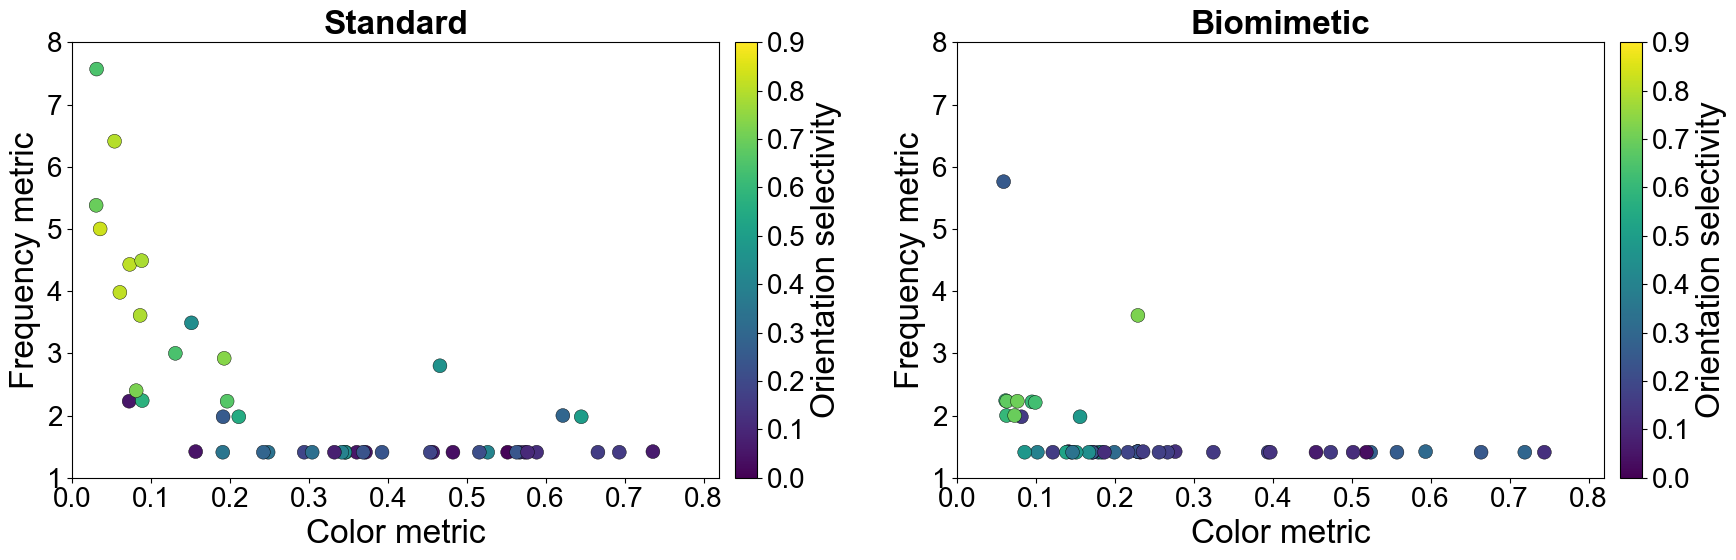

In [9]:
create_rf_scatterplot(regimen_list, regimen_names, color_ind_all[0], alt_fftfreq_ind_all[0], fftaz_ind_all[0], 
                      os.path.join(figure_path, "alternative_fft_index_scatter.png"), freq_range=(1, 8))

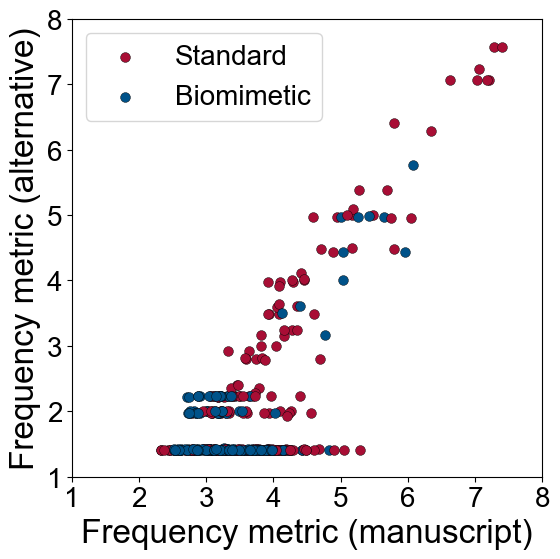

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

for repeat in range(5):
    for j, regimen in enumerate(regimen_list):
        s = ax.scatter(fftfreq_ind_all[repeat][j], alt_fftfreq_ind_all[repeat][j], color=colors[j], 
                        vmin=0, vmax=0.9, s=50, edgecolors='black', linewidth=0.3)

    ax.set_xlabel("Frequency metric (manuscript)")
    ax.set_ylabel("Frequency metric (alternative)")
    ax.set_xlim([1, 8])
    ax.set_ylim([1, 8])
    ax.set_xticks(np.arange(1, 9, 1))
    ax.set_yticks(np.arange(1, 9, 1))
    ax.legend(regimen_names)

plt.tight_layout()
fig.savefig(os.path.join(figure_path, "alternative_fft_index_comparison.png"), dpi=DPI)

## Top 12 and top 1 color index

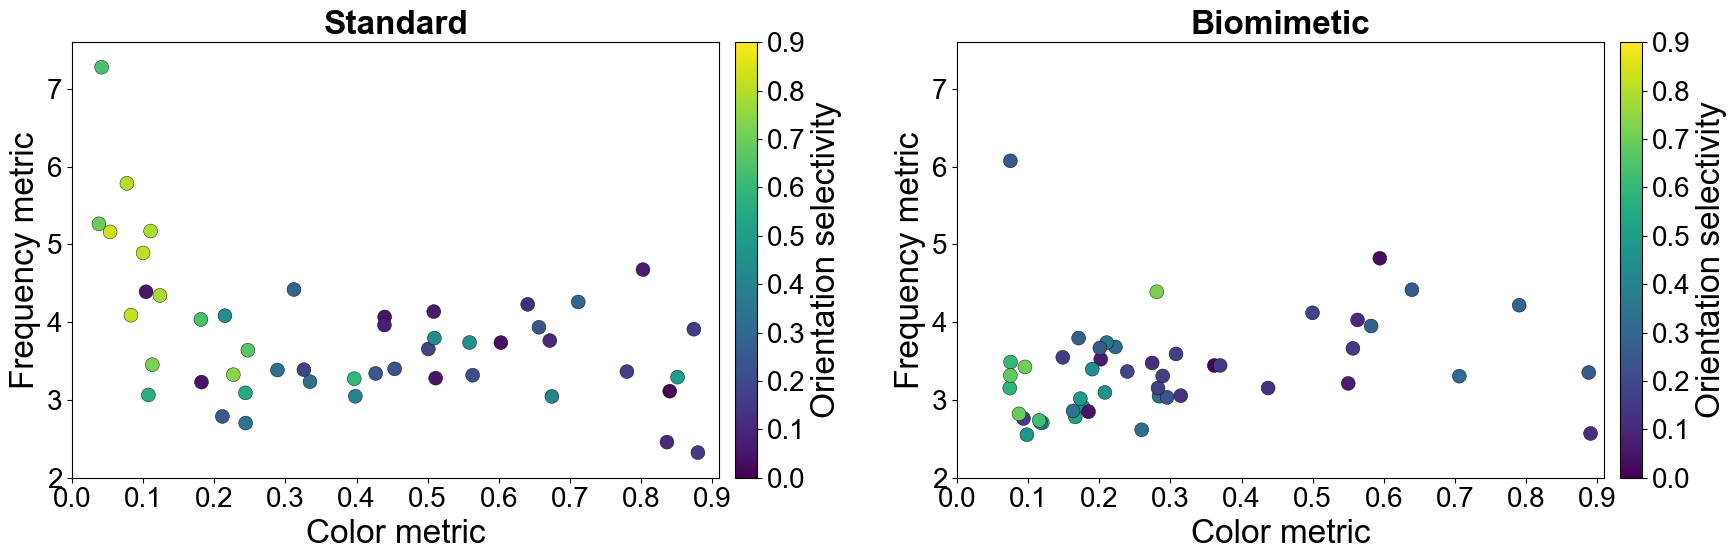

In [11]:
create_rf_scatterplot(regimen_list, regimen_names, color_ind_12_all[0], fftfreq_ind_all[0], fftaz_ind_all[0], 
                      os.path.join(figure_path, "top12_color_index_scatter.png"), col_max=0.91)

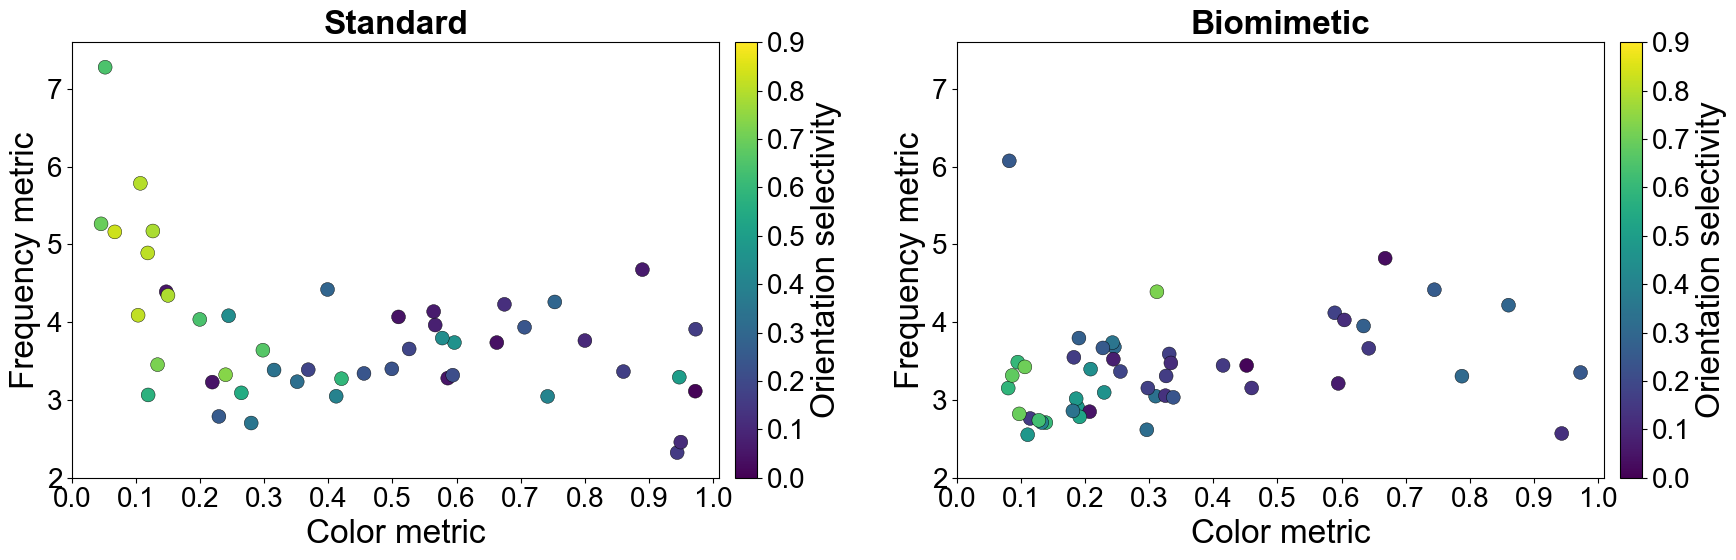

In [12]:
create_rf_scatterplot(regimen_list, regimen_names, color_ind_1_all[0], fftfreq_ind_all[0], fftaz_ind_all[0], 
                      os.path.join(figure_path, "top1_color_index_scatter.png"), col_max=1.01)

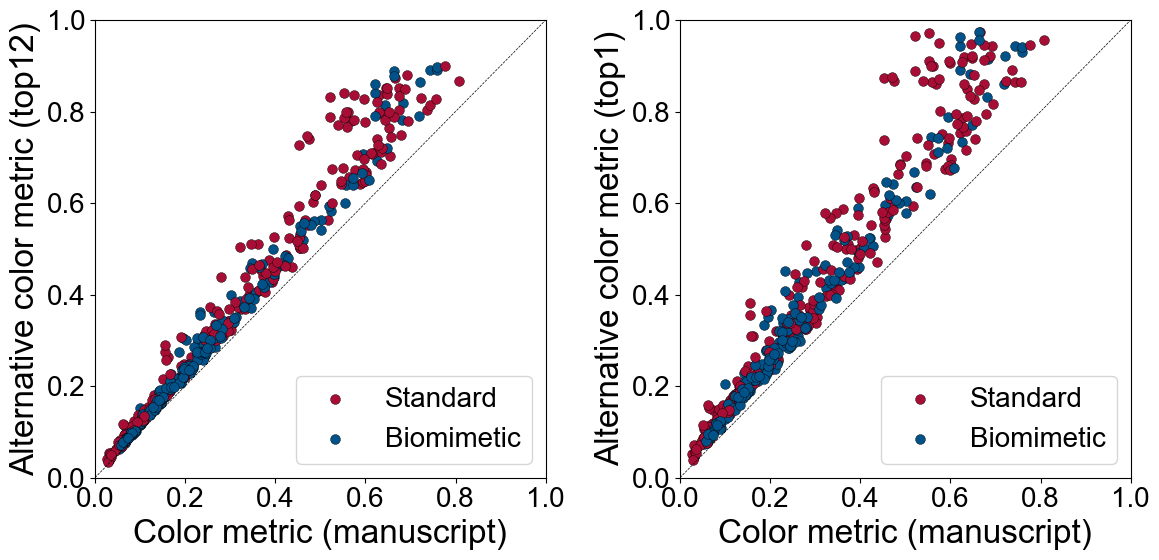

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
metric_names = ["top12", "top1"]

for i, alt_color_ind_all in enumerate([color_ind_12_all, color_ind_1_all]):
    for repeat in range(5):
        for j, regimen in enumerate(regimen_list):
            ax[i].scatter(color_ind_all[repeat][j], alt_color_ind_all[repeat][j], color=colors[j], 
                          vmin=0, vmax=0.9, s=50, edgecolors='black', linewidth=0.3)

    ax[i].plot([0, 1], [0, 1], color='black', linestyle='--', linewidth=0.5)
    ax[i].set_xlabel("Color metric (manuscript)")
    ax[i].set_ylabel("Alternative color metric (" + metric_names[i] + ")")
    ax[i].set_xlim([0, 1])
    ax[i].set_ylim([0, 1])
    ax[i].set_xticks(np.arange(0, 1.1, 0.2))
    ax[i].set_yticks(np.arange(0, 1.1, 0.2))
    ax[i].legend(regimen_names)

plt.tight_layout()
fig.savefig(os.path.join(figure_path, "top12_top1_color_index_comparison.png"), dpi=DPI)

## HSV and CIELAB color index

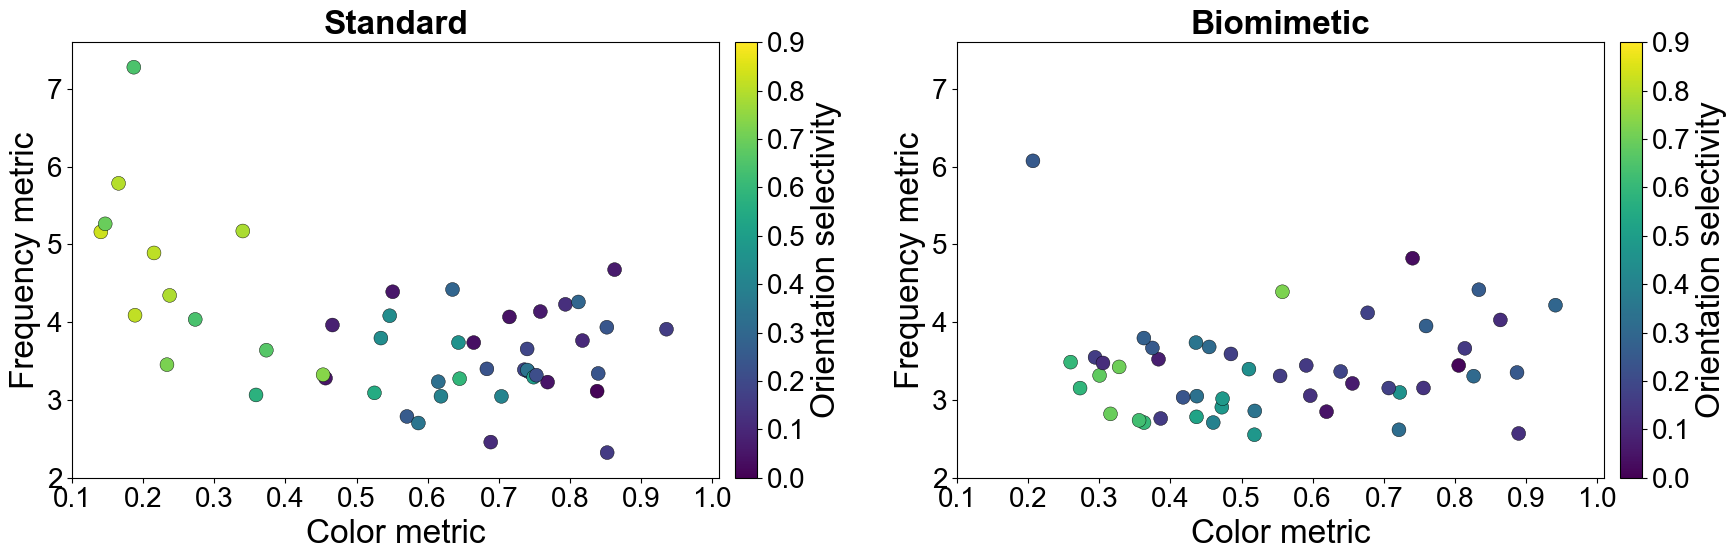

In [14]:
create_rf_scatterplot(regimen_list, regimen_names, color_ind_HSV_all[0], fftfreq_ind_all[0], fftaz_ind_all[0],
                      os.path.join(figure_path, "hsv_color_index_scatter.png"), col_max=1.01, col_min=0.1, col_step=0.1)

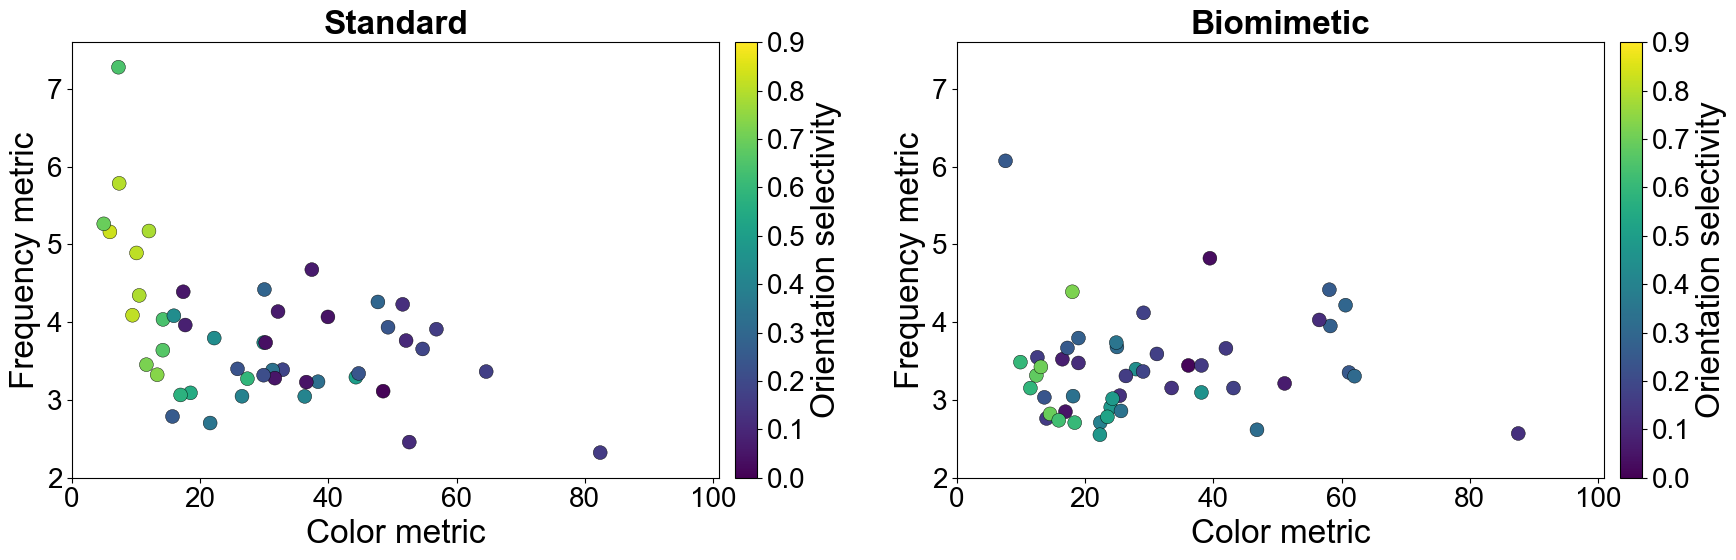

In [15]:
create_rf_scatterplot(regimen_list, regimen_names, color_ind_CIELAB_all[0], fftfreq_ind_all[0], fftaz_ind_all[0], 
                      os.path.join(figure_path, "cielab_color_index_scatter.png"), col_max=101, col_min=0, col_step=20)

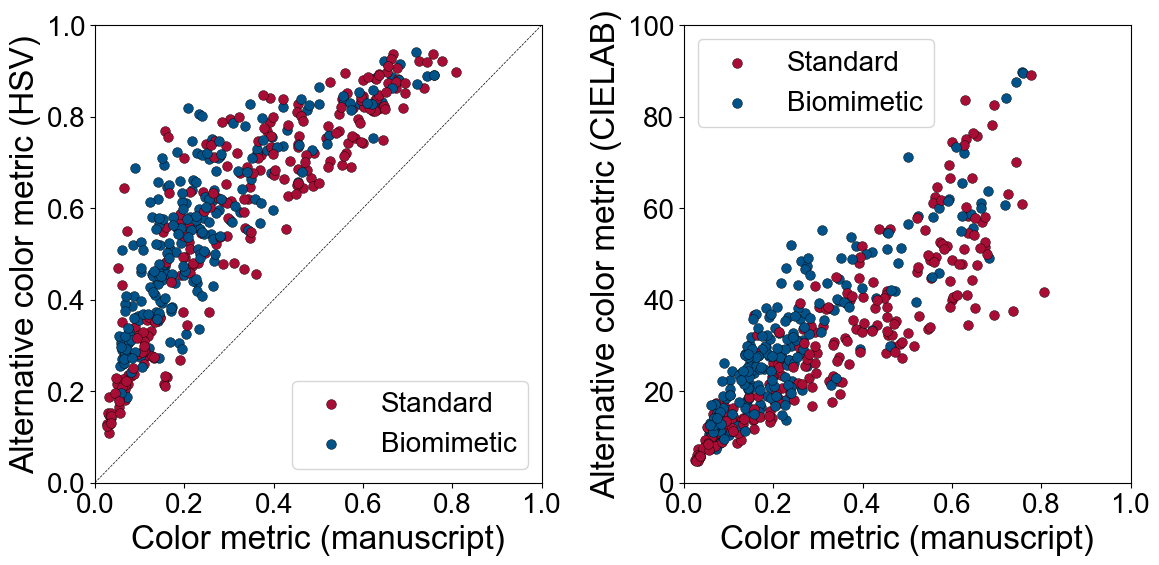

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
metric_names = ["HSV", "CIELAB"]

for i, alt_color_ind_all in enumerate([color_ind_HSV_all, color_ind_CIELAB_all]):
    for repeat in range(5):
        for j, regimen in enumerate(regimen_list):
            ax[i].scatter(color_ind_all[repeat][j], alt_color_ind_all[repeat][j], color=colors[j], 
                          vmin=0, vmax=0.9, s=50, edgecolors='black', linewidth=0.3)

    ax[i].set_xlabel("Color metric (manuscript)")
    ax[i].set_ylabel("Alternative color metric (" + metric_names[i] + ")")
    ax[i].set_xlim([0, 1])
    ax[i].set_xticks(np.arange(0, 1.1, 0.2))
    ax[i].legend(regimen_names)

ax[0].plot([0, 1], [0, 1], color='black', linestyle='--', linewidth=0.5)
ax[0].set_ylim([0, 1])
ax[0].set_yticks(np.arange(0, 1.1, 0.2))
ax[1].set_ylim([0, 100])
ax[1].set_yticks(np.arange(0, 101, 20))

plt.tight_layout()
fig.savefig(os.path.join(figure_path, "hsv_cielab_color_index_comparison.png"), dpi=DPI)